In [1]:
# conda environment (project)
# /home/student/.conda/envs/project/bin/python 
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os, gc
import torch

from transformers import set_seed
from datasets import load_dataset
from evaluate import *
from arc import ARCSolver

from datasets import Dataset
from utils import render_grid

In [2]:
# prepare the test dataset
data_path = "dataset"
dataset, task_list = load_data(data_path)
df300 = sample_data(dataset, task_list, n_row=30000) 
df300.head(5) 

Imported 300 different tasks in the dataset.
# of samples in a task: min(82), Q1(1000), Q2(1000), Q3(1000), max(1000), mean(897.7)


,task,train,test_input,test_output,test
0,239be575,"[{'input': [[0, 0, 6, 6, 2, 0, 0], [2, 0, 6, 6...","[{'input': [[0, 5, 5, 3, 3, 3, 0], [0, 5, 5, 0...",[[[0]]],"[{'input': [[0, 5, 5, 3, 3, 3, 0], [0, 5, 5, 0..."
1,4258a5f9,"[{'input': [[3, 3, 3, 3], [3, 3, 3, 3], [3, 3,...","[{'input': [[6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 2...","[[[6, 6, 6, 1, 1, 1], [1, 1, 1, 1, 2, 1], [1, ...","[{'input': [[6, 6, 6, 6, 6, 6], [6, 6, 6, 6, 2..."
2,1caeab9d,"[{'input': [[6, 6, 6, 6, 6, 6, 6], [6, 6, 8, 8...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4...","[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,...","[{'input': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [4..."
3,623ea044,"[{'input': [[3, 3, 3, 3, 3, 3, 3], [3, 3, 3, 3...","[{'input': [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], ...","[[[6, 8, 6, 6, 6], [6, 6, 8, 6, 8], [6, 6, 6, ...","[{'input': [[6, 6, 6, 6, 6], [6, 6, 6, 6, 6], ..."
4,e9afcf9a,"[{'input': [[4, 4, 4, 4, 4], [6, 6, 6, 6, 6], ...","[{'input': [[5, 5, 5, 5, 5, 5, 5, 5, 5], [7, 7...","[[[5, 7, 5, 7, 5, 7, 5, 7, 5], [7, 0, 7, 0, 7,...","[{'input': [[5, 5, 5, 5, 5, 5, 5, 5, 5], [7, 7..."


In [3]:
# prepare samples for each task
task_samples = []
for t in range(300):
    df = sample_data(dataset, task_list, n_row=1000, indices=[t])
    task_samples.append(df)

In [ ]:
# Visualize a task (EDA)
task_idx = 11 # select which task you want to examine
n_sample = 1
for task_idx in [10, 40, 69, 92, 17, 46, 18, 35, 41, 51, 61, 65, 67, 83, 85, 87, 90, 98, 99]:
    print(task_idx)
    for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(n_sample)):
        for case in data['train']:
            print("==================================================")
            print("Example input")
            render_grid(case['input'])
            print("Example output")
            render_grid(case['output'])
            break
        print("==================================================")
        print("Example test input")
        render_grid(data['test'][0]['input'])
        print("Example test output")
        render_grid(data['test'][0]['output'])
    print("==================================================")

In [4]:
simple_tasks = []
for task_idx in range(300):
    check = True
    for data in Dataset.from_pandas(task_samples[task_idx]).shuffle().select(range(3)):
        for case in data['train']:
            wi, hi = len(case['input'][0]), len(case['input'])
            wo, ho = len(case['output'][0]), len(case['output'])
            if (wi!=wo) or (hi!=ho): check = False
        case = data['test'][0]
        wi, hi = len(case['input'][0]), len(case['input'])
        wo, ho = len(case['output'][0]), len(case['output'])
        if (wi!=wo) or (hi!=ho): check = False
    if check: simple_tasks.append(task_idx)
print(simple_tasks)

[0, 1, 3, 7, 8, 9, 10, 11, 13, 15, 18, 19, 20, 22, 27, 29, 30, 32, 33, 34, 35, 38, 40, 41, 44, 45, 46, 51, 52, 54, 55, 56, 57, 58, 61, 64, 65, 66, 67, 68, 69, 70, 72, 73, 75, 78, 79, 80, 81, 83, 85, 87, 89, 90, 91, 92, 93, 95, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 110, 111, 113, 114, 116, 117, 118, 119, 120, 123, 124, 128, 129, 130, 133, 135, 137, 138, 139, 140, 141, 142, 143, 145, 147, 148, 150, 151, 153, 154, 155, 157, 158, 159, 160, 161, 162, 166, 167, 169, 170, 172, 173, 174, 175, 176, 177, 178, 179, 181, 182, 185, 188, 190, 193, 194, 195, 196, 197, 198, 201, 203, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 218, 220, 222, 224, 225, 226, 227, 228, 230, 231, 233, 234, 235, 236, 239, 244, 245, 246, 248, 249, 250, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 267, 268, 270, 271, 273, 274, 275, 276, 277, 281, 282, 285, 286, 287, 291, 292, 293, 295, 296, 297]


In [5]:
set_seed(1234567890)
token = os.environ.get("HF_TOKEN", None)
solver = ARCSolver(model_id="Qwen/Qwen3-4B", token=token)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
solver.prepare_train()
n_train = len(simple_tasks[:20])*500
n_eval = 500
dfsimple = sample_data(dataset, task_list, n_row=n_train+n_eval, indices=simple_tasks)
train_dataset = Dataset.from_pandas(dfsimple).select(range(n_train))
solver.train(train_dataset)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

<|im_start|>system
You are an expert for solving logical puzzles. You are given some pairs of input and output as coordinates of 2D grid with the same underlying spatial pattern between them. The grid is given as their width, height, and coordinates of pixels filled with each certain colors. You have to logically infer the exact rule that transforms each input to the corresponding output.<|im_end|>
<|im_start|>user
Here are three examples of input and corresponding output. You have to examine given examples and learn the common specific patterns that transforms each input to the corresponding output.
----------------------------------------
input:
The grid has a width of 7, and a height of 8.
So, there are total 56 pixels in the grid, colored:
1 green pixels on coordinates [(7,1)],
1 yellow pixels on coordinates [(5,3)],
54 white pixels on the rest.
output for the given input:
The grid has a width of 7, and a height of 8.
So, there are total 56 pixels in the grid, colored:
1 green pixe

Truncating train dataset:   0%|          | 0/8429 [00:00<?, ? examples/s]

[2025-06-02 01:59:50,518] [INFO] [real_accelerator.py:254:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
/usr/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss
50,3.105800
100,0.023700
150,0.021300
200,0.021400
250,0.018500
300,0.018300
350,0.018900
400,0.018200
450,0.018000
500,0.017400


In [8]:
n_eval = 20
solver.prepare_evaluation(select_adapter="20250602_015949") # make sure you set the right model

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Test input


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 2, 2, 6, 6]
                      [6, 6, 6, 6, 6, 2, 2, 2, 9, 6]
                      [6, 6, 6, 6, 6, 9, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Predict output
output for the given input:
The grid has a width of 10, and a height of 8.
So, there are total 80 pixels in the grid, colored:
8 green pixels on coordinates [(3,7), (3,8), (3,9), (4,6), (4,7), (4,8), (4,9), (5,8)],
4 orange pixels on coordinates [(3,10), (4,9), (5,6), (6,7)],
68 cyan pixels on the rest.

<|im_end|>


                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 2 2 2 9]
                      [6 6 6 6 6 2 2 2 9 6]
                      [6 6 6 6 6 9 6 2 6 6]
                      [6 6 6 6 6 6 9 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]
                      [6 6 6 6 6 6 6 6 6 6]

Test output


                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 9, 2, 9, 9, 6]
                      [6, 6, 6, 6, 6, 9, 2, 2, 2, 6]
                      [6, 6, 6, 6, 6, 2, 2, 2, 9, 6]
                      [6, 6, 6, 6, 6, 9, 9, 2, 9, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
                      [6, 6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                  [2, 2, 2, 2, 2, 2, 2, 2]
                  [2, 0, 0, 0, 0, 0, 0, 2]
                  [2, 0, 7, 7, 7, 7, 0, 2]
                  [2, 0, 7, 3, 3, 7, 0, 2]
                  [2, 0, 7, 3, 3, 7, 0, 2]
                  [2, 0, 7, 3, 3, 7, 0, 2]
                  [2, 0, 7, 3, 3, 7, 0, 2]
                  [2, 0, 7, 7, 7, 7, 0, 2]
                  [2, 0, 0, 0, 0, 0, 0, 2]
                  [2, 2, 2, 2, 2, 2, 2, 2]

Predict output
output for the given input:
The grid has a width of 8, and a height of 10.
So, there are total 80 pixels in the grid, colored:
16 black pixels on coordinates [(2,2), (2,3), (2,4), (2,5), (2,6), (2,7), (3,2), (3,7), (4,2), (4,7), (5,2), (5,7), (6,2), (6,7), (7,2), (7,7)],
16 yellow pixels on coordinates [(4,4), (4,5), (5,4), (5,5), (6,4), (6,5), (7,4), (7,5), (8,4), (8,5), (9,4), (9,5), (10,4), (10,5), (11,4), (11,5)],
8 white pixels on coordinates [(3,3), (3,4), (3,5), (3,6), (4,3), (4,6), (5,3), (5,6)],
32 green pixels on the rest.

<|im_end|>


                  [2 2 2 2 2 2 2 2]
                  [2 0 0 0 0 0 0 2]
                  [2 0 7 7 7 7 0 2]
                  [2 0 7 3 3 7 0 2]
                  [2 0 7 3 3 7 0 2]
                  [2 0 2 3 3 2 0 2]
                  [2 0 2 3 3 2 0 2]
                  [2 2 2 3 3 2 2 2]
                  [2 2 2 3 3 2 2 2]
                  [2 2 2 3 3 2 2 2]

Test output


                  [3, 3, 3, 3, 3, 3, 3, 3]
                  [3, 2, 2, 2, 2, 2, 2, 3]
                  [3, 2, 0, 0, 0, 0, 2, 3]
                  [3, 2, 0, 7, 7, 0, 2, 3]
                  [3, 2, 0, 7, 7, 0, 2, 3]
                  [3, 2, 0, 7, 7, 0, 2, 3]
                  [3, 2, 0, 7, 7, 0, 2, 3]
                  [3, 2, 0, 0, 0, 0, 2, 3]
                  [3, 2, 2, 2, 2, 2, 2, 3]
                  [3, 3, 3, 3, 3, 3, 3, 3]

Test input


              [8, 9, 8, 8, 8, 8]
              [8, 2, 8, 8, 8, 8]
              [8, 8, 8, 8, 8, 8]
              [8, 8, 8, 8, 8, 8]
              [8, 8, 8, 8, 8, 9]
              [8, 8, 8, 5, 8, 2]
              [8, 8, 8, 8, 8, 8]
              [8, 8, 8, 3, 8, 8]
              [5, 8, 8, 8, 8, 8]
              [8, 8, 8, 8, 8, 3]

Predict output
output for the given input:
The grid has a width of 6, and a height of 10.
So, there are total 60 pixels in the grid, colored:
4 green pixels on coordinates [(2,2), (3,3), (4,4), (5,5)],
4 yellow pixels on coordinates [(8,4), (9,5), (10,6)],
3 magenta pixels on coordinates [(6,4), (7,3), (8,2)],
5 orange pixels on coordinates [(1,2), (2,3), (3,4), (4,5), (5,6)],
44 purple pixels on the rest.

<|im_end|>


              [8 9 8 8 8 8]
              [8 2 9 8 8 8]
              [8 8 2 9 8 8]
              [8 8 8 2 9 8]
              [8 8 8 8 2 9]
              [8 8 8 5 8 8]
              [8 8 5 8 8 8]
              [8 5 8 3 8 8]
              [8 8 8 8 3 8]
              [8 8 8 8 8 3]

Test output


              [8, 9, 8, 8, 8, 8]
              [8, 2, 9, 8, 8, 8]
              [8, 8, 2, 9, 8, 8]
              [8, 8, 8, 2, 9, 8]
              [8, 8, 8, 8, 2, 9]
              [8, 8, 8, 5, 8, 2]
              [8, 8, 5, 8, 8, 8]
              [8, 5, 8, 3, 8, 8]
              [5, 8, 8, 8, 3, 8]
              [8, 8, 8, 8, 8, 3]

Test input


                    [0, 1, 2, 0, 0, 0, 1, 0, 2]
                    [0, 1, 1, 2, 2, 1, 2, 2, 0]
                    [1, 1, 1, 1, 2, 2, 2, 0, 0]
                    [1, 0, 0, 0, 1, 2, 0, 0, 1]
                    [0, 1, 0, 1, 0, 1, 0, 0, 0]

Predict output
output for the given input:
The grid has a width of 9, and a height of 5.
So, there are total 45 pixels in the grid, colored:
18 red pixels on coordinates [(1,2), (1,7), (2,2), (2,3), (2,6), (3,1), (3,2), (3,3), (3,4), (4,1), (4,5), (4,6), (4,9), (5,2), (5,4), (5,6), (5,8), (5,9)],
10 green pixels on coordinates [(1,3), (1,9), (2,4), (2,5), (2,7), (2,8), (3,5), (3,6), (3,7), (4,6)],
17 black pixels on the rest.

<|im_end|>


                    [0 1 2 0 0 0 1 0 2]
                    [0 1 1 2 2 1 2 2 0]
                    [1 1 1 1 2 2 2 0 0]
                    [1 0 0 0 1 2 0 0 1]
                    [0 1 0 1 0 1 0 1 1]

Test output


                    [0, 1, 2, 0, 0, 1, 1, 0, 2]
                    [0, 1, 1, 2, 2, 1, 2, 2, 0]
                    [1, 1, 1, 1, 2, 2, 2, 0, 0]
                    [1, 0, 0, 0, 1, 2, 0, 0, 1]
                    [0, 1, 0, 1, 0, 1, 0, 0, 0]

Test input


                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [5, 9, 9, 9, 9, 9, 9, 9]
                  [5, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 2, 2, 9, 9, 9, 9]
                  [2, 9, 2, 2, 9, 9, 9, 9]
                  [2, 2, 2, 2, 9, 9, 9, 9]
                  [2, 2, 2, 2, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]

Predict output
output for the given input:
The grid has a width of 8, and a height of 10.
So, there are total 80 pixels in the grid, colored:
13 green pixels on coordinates [(6,2), (6,3), (7,1), (7,2), (7,3), (8,1), (8,2), (8,3), (8,4), (9,1), (9,2), (9,3), (9,4)],
2 magenta pixels on coordinates [(3,1), (4,1)],
65 orange pixels on the rest.

<|im_end|>


                  [9 9 9 9 9 9 9 9]
                  [9 9 9 9 9 9 9 9]
                  [5 9 9 9 9 9 9 9]
                  [5 9 9 9 9 9 9 9]
                  [9 9 9 9 9 9 9 9]
                  [9 2 2 9 9 9 9 9]
                  [2 2 2 9 9 9 9 9]
                  [2 2 2 2 9 9 9 9]
                  [2 2 2 2 9 9 9 9]
                  [9 9 9 9 9 9 9 9]

Test output


                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [5, 9, 9, 9, 9, 9, 9, 9]
                  [5, 9, 2, 2, 9, 9, 9, 9]
                  [2, 9, 2, 2, 9, 9, 9, 9]
                  [2, 2, 2, 2, 9, 9, 9, 9]
                  [2, 2, 2, 2, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]
                  [9, 9, 9, 9, 9, 9, 9, 9]

Test input


                  [8, 8, 8, 8, 8, 8, 8, 5]
                  [8, 8, 8, 8, 8, 8, 9, 6]
                  [8, 8, 8, 8, 8, 2, 3, 6]
                  [8, 8, 8, 8, 8, 4, 5, 6]
                  [8, 8, 8, 8, 8, 9, 3, 6]

Predict output
output for the given input:
The grid has a width of 8, and a height of 5.
So, there are total 40 pixels in the grid, colored:
2 green pixels on coordinates [(3,6), (3,8)],
4 yellow pixels on coordinates [(3,7), (3,9), (5,7), (5,9)],
2 blue pixels on coordinates [(4,6), (4,8)],
4 magenta pixels on coordinates [(1,8), (1,9), (4,7), (4,9)],
8 cyan pixels on coordinates [(2,8), (2,9), (3,8), (3,9), (4,8), (4,9), (5,8), (5,9)],
4 orange pixels on coordinates [(2,7), (2,9), (5,6), (5,8)],
22 purple pixels on the rest.

<|im_end|>


                  [8 8 8 8 8 8 8 5]
                  [8 8 8 8 8 8 9 6]
                  [8 8 8 8 8 2 3 6]
                  [8 8 8 8 8 4 5 6]
                  [8 8 8 8 8 9 3 9]

Test output


                  [5, 8, 8, 8, 8, 8, 8, 5]
                  [6, 9, 8, 8, 8, 8, 9, 6]
                  [6, 3, 2, 8, 8, 2, 3, 6]
                  [6, 5, 4, 8, 8, 4, 5, 6]
                  [6, 3, 9, 8, 8, 9, 3, 6]

Test input


                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 6]
                      [5, 5, 5, 5, 5, 5, 5, 5, 4, 4]
                      [5, 5, 5, 5, 5, 5, 5, 5, 6, 4]
                      [5, 5, 5, 5, 5, 5, 5, 5, 7, 8]
                      [5, 5, 5, 5, 5, 5, 8, 8, 7, 2]
                      [5, 5, 5, 5, 5, 5, 5, 5, 7, 8]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 6]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

Predict output
output for the given input:
The grid has a width of 10, and a height of 9.
So, there are total 90 pixels in the grid, colored:
2 green pixels on coordinates [(5,1), (5,10)],
6 blue pixels on coordinates [(2,1), (2,9), (2,10), (3,1), (3,10), (7,1)],
6 cyan pixels on coordinates [(1,1), (1,10), (3,2), (3,9), (7,2), (7,10)],
6 white pixels on coordinates [(4,1), (4,9), (4,10), (5,2), (5,7), (5,8)],
12 purple pixels on coordinates [(4,2), (4,10), (5,1), (5,3), (5,4), (5,8), (5,9), (6,1), (6,10), (6,3), (6,4), (6,9)],
58 magenta pixels on the rest.

<|im_end|>


                      [6 5 5 5 5 5 5 5 5 6]
                      [4 5 5 5 5 5 5 5 4 4]
                      [4 6 5 5 5 5 5 5 6 4]
                      [7 8 5 5 5 5 5 5 7 8]
                      [8 7 8 8 5 5 7 8 8 2]
                      [8 5 8 8 5 5 5 5 8 8]
                      [4 6 5 5 5 5 5 5 5 6]
                      [5 5 5 5 5 5 5 5 5 5]
                      [5 5 5 5 5 5 5 5 5 5]

Test output


                      [6, 5, 5, 5, 5, 5, 5, 5, 5, 6]
                      [4, 4, 5, 5, 5, 5, 5, 5, 4, 4]
                      [4, 6, 5, 5, 5, 5, 5, 5, 6, 4]
                      [8, 7, 5, 5, 5, 5, 5, 5, 7, 8]
                      [2, 7, 8, 8, 5, 5, 8, 8, 7, 2]
                      [8, 7, 5, 5, 5, 5, 5, 5, 7, 8]
                      [6, 5, 5, 5, 5, 5, 5, 5, 5, 6]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
                      [5, 5, 5, 5, 5, 5, 5, 5, 5, 5]

Test input


                  [7, 6, 6, 9, 6, 2, 3, 3]
                  [7, 1, 0, 6, 7, 1, 8, 4]
                  [4, 9, 0, 1, 6, 1, 0, 1]
                  [8, 8, 2, 2, 8, 6, 9, 6]
                  [2, 3, 7, 0, 2, 5, 8, 3]
                  [4, 0, 8, 0, 6, 6, 9, 2]
                  [3, 9, 1, 9, 6, 0, 1, 0]
                  [5, 7, 6, 4, 8, 0, 6, 0]
                  [3, 8, 9, 6, 7, 6, 7, 8]
                  [2, 6, 4, 9, 6, 6, 6, 6]

Predict output
output for the given input:
The grid has a width of 8, and a height of 10.
So, there are total 80 pixels in the grid, colored:
10 black pixels on coordinates [(2,3), (3,3), (3,7), (5,4), (6,2), (6,4), (7,6), (7,8), (8,6), (8,8)],
7 red pixels on coordinates [(2,2), (2,6), (3,4), (3,6), (3,8), (7,3), (7,7)],
17 green pixels on coordinates [(1,6), (4,3), (4,4), (5,1), (5,5), (6,8), (10,1), (10,2), (10,3), (10,4), (10,5), (10,6), (10,7), (10,8), (9,6), (9,7), (9,8)],
6 yellow pixels on coordinates [(1,7), (1,8), (5,2), (5,8), (7,1), (9,1)],
5 blue pixels on coordinates [(2,8), (3,1), (6,1), (8,4), (10,3)],
2 magenta pixels on coordinates [(5,6), (8,1)],
7 white pixels on coordinates [(1,1), (2,1), (2,5), (5,3), (8,2), (9,5), (9,7)],
9 purple pixels on coordinates [(2,7), (4,1), (4,2), (4,5), (5,7), (6,3), (8,5), (9,2), (9,8)],
8 orange pixels on coordinates [(1,4), (3,2), (4,7), (6,7), (7,2), (7,4), (9,3), (10,4)],
19 cyan pixels on the rest.

<|im_end|>


                  [7 6 6 9 6 2 3 3]
                  [7 1 0 6 7 1 8 4]
                  [4 9 0 1 6 1 0 1]
                  [8 8 2 2 8 6 9 6]
                  [2 3 7 0 2 5 8 3]
                  [4 0 8 0 6 6 9 2]
                  [3 9 1 9 6 0 1 0]
                  [5 7 6 4 8 0 6 0]
                  [3 8 9 6 7 2 7 8]
                  [2 2 4 9 2 2 2 2]

Test output


                  [7, 2, 2, 9, 2, 2, 3, 3]
                  [7, 1, 0, 2, 7, 1, 8, 4]
                  [4, 9, 0, 1, 2, 1, 0, 1]
                  [8, 8, 2, 2, 8, 2, 9, 2]
                  [2, 3, 7, 0, 2, 5, 8, 3]
                  [4, 0, 8, 0, 2, 2, 9, 2]
                  [3, 9, 1, 9, 2, 0, 1, 0]
                  [5, 7, 2, 4, 8, 0, 2, 0]
                  [3, 8, 9, 2, 7, 2, 7, 8]
                  [2, 2, 4, 9, 2, 2, 2, 2]

Test input


                      [7, 4, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [6, 6, 6, 7, 7, 7, 7, 7, 7, 7]
                      [6, 7, 6, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [6, 7, 6, 7, 7, 7, 7, 7, 7, 7]
                      [6, 6, 6, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 4, 7, 7, 7, 7, 7, 7, 7, 7]

Predict output
output for the given input:
The grid has a width of 10, and a height of 10.
So, there are total 100 pixels in the grid, colored:
2 blue pixels on coordinates [(1,4), (10,4)],
10 cyan pixels on coordinates [(3,1), (3,2), (3,3), (4,1), (4,3), (7,1), (7,3), (8,1), (8,2), (8,3)],
88 white pixels on the rest.

<|im_end|>


                      [7 7 7 4 7 7 7 7 7 7]
                      [7 7 7 7 7 7 7 7 7 7]
                      [6 6 6 7 7 7 7 7 7 7]
                      [6 7 6 7 7 7 7 7 7 7]
                      [7 7 7 7 7 7 7 7 7 7]
                      [7 7 7 7 7 7 7 7 7 7]
                      [6 7 6 7 7 7 7 7 7 7]
                      [6 6 6 7 7 7 7 7 7 7]
                      [7 7 7 7 7 7 7 7 7 7]
                      [7 7 7 4 7 7 7 7 7 7]

Test output


                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [6, 6, 6, 7, 7, 7, 7, 7, 7, 7]
                      [6, 7, 6, 7, 7, 7, 7, 7, 7, 7]
                      [7, 4, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 4, 7, 7, 7, 7, 7, 7, 7, 7]
                      [6, 7, 6, 7, 7, 7, 7, 7, 7, 7]
                      [6, 6, 6, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 7, 7, 7, 7, 7, 7, 7, 7]

Test input


                    [0, 0, 0, 0, 5, 0, 0, 0, 0]
                    [2, 0, 0, 0, 5, 0, 0, 0, 0]
                    [0, 0, 0, 0, 5, 0, 0, 0, 0]
                    [0, 0, 0, 0, 5, 0, 0, 0, 3]
                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [0, 0, 3, 0, 5, 0, 1, 0, 0]
                    [0, 0, 0, 0, 5, 0, 0, 0, 0]
                    [0, 0, 0, 0, 5, 0, 0, 0, 0]
                    [0, 0, 0, 0, 5, 0, 0, 0, 0]

Predict output
output for the given input:
The grid has a width of 9, and a height of 9.
So, there are total 81 pixels in the grid, colored:
17 magenta pixels on coordinates [(1,5), (2,5), (3,5), (4,5), (5,1), (5,2), (5,3), (5,4), (5,5), (5,6), (5,7), (5,8), (5,9), (6,5), (7,5), (8,5), (9,5)],
18 white pixels on coordinates [(1,1), (1,2), (1,3), (1,4), (2,1), (2,2), (2,3), (2,4), (3,1), (3,2), (3,3), (3,4), (4,1), (4,2), (4,3), (4,4), (6,1), (6,2)],
18 purple pixels on coordinates [(1,6), (1,7), (1,8), (1,9), (2,6), (2,7), (2,8), (2,9), (3,6), (3,7), (3,8), (3,9), (4,6), (4,7), (4,8), (4,9), (6,6), (6,7)],
18 orange pixels on coordinates [(5,10), (5,11), (5,12), (5,13), (5,14), (5,15), (5,16), (5,17), (5,18), (6,10), (6,11), (6,12), (6,13), (6,14), (6,15), (6,16), (6,17), (6,18)],
0 black pixels on the rest.

<|im_end|>


                    [7 7 7 7 5 8 8 8 8]
                    [7 7 7 7 5 8 8 8 8]
                    [7 7 7 7 5 8 8 8 8]
                    [7 7 7 7 5 8 8 8 8]
                    [5 5 5 5 5 5 5 5 5]
                    [7 7 0 0 5 8 8 0 0]
                    [0 0 0 0 5 0 0 0 0]
                    [0 0 0 0 5 0 0 0 0]
                    [0 0 0 0 5 0 0 0 0]

Test output


                    [7, 7, 7, 7, 5, 8, 8, 8, 8]
                    [7, 7, 7, 7, 5, 8, 8, 8, 8]
                    [7, 7, 7, 7, 5, 8, 8, 8, 8]
                    [7, 7, 7, 7, 5, 8, 8, 8, 8]
                    [5, 5, 5, 5, 5, 5, 5, 5, 5]
                    [8, 8, 8, 8, 5, 6, 6, 6, 6]
                    [8, 8, 8, 8, 5, 6, 6, 6, 6]
                    [8, 8, 8, 8, 5, 6, 6, 6, 6]
                    [8, 8, 8, 8, 5, 6, 6, 6, 6]

Test input


                  [2, 4, 4, 4, 4, 4, 4, 1]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [0, 4, 4, 4, 4, 4, 4, 9]

Predict output
output for the given input:
The grid has a width of 8, and a height of 8.
So, there are total 64 pixels in the grid, colored:
8 black pixels on coordinates [(2,1), (3,1), (4,1), (5,1), (6,1), (7,1), (8,1), (8,2)],
8 red pixels on coordinates [(1,6), (1,8), (2,6), (2,8), (3,6), (3,8), (4,6), (4,8)],
8 green pixels on coordinates [(1,1), (1,3), (1,5), (1,7), (2,3), (2,5), (2,7), (3,3)],
8 orange pixels on coordinates [(5,7), (5,8), (6,7), (6,8), (7,7), (7,8), (8,7), (8,8)],
32 blue pixels on the rest.

<|im_end|>


                  [2 4 2 4 2 1 2 1]
                  [0 4 2 4 2 1 2 1]
                  [0 4 2 4 4 1 4 1]
                  [0 4 4 4 4 1 4 1]
                  [0 4 4 4 4 4 9 9]
                  [0 4 4 4 4 4 9 9]
                  [0 4 4 4 4 4 9 9]
                  [0 0 4 4 4 4 9 9]

Test output


                  [2, 4, 2, 4, 4, 1, 4, 1]
                  [4, 4, 2, 4, 4, 1, 4, 4]
                  [2, 2, 2, 4, 4, 1, 1, 1]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [4, 4, 4, 4, 4, 4, 4, 4]
                  [0, 0, 0, 4, 4, 9, 9, 9]
                  [4, 4, 0, 4, 4, 9, 4, 4]
                  [0, 4, 0, 4, 4, 9, 4, 9]

Test input


                [4, 4, 4, 4, 4, 4, 4]
                [4, 4, 4, 4, 4, 4, 4]
                [4, 4, 4, 4, 4, 4, 4]
                [4, 4, 4, 0, 4, 4, 4]
                [4, 4, 4, 4, 0, 4, 4]
                [4, 4, 4, 4, 4, 4, 4]

Predict output
output for the given input:
The grid has a width of 7, and a height of 6.
So, there are total 42 pixels in the grid, colored:
2 black pixels on coordinates [(4,4), (5,5)],
2 purple pixels on coordinates [(3,3), (6,6)],
38 blue pixels on the rest.

<|im_end|>


                [4 4 4 4 4 4 4]
                [4 4 4 4 4 4 4]
                [4 4 8 4 4 4 4]
                [4 4 4 0 4 4 4]
                [4 4 4 4 0 4 4]
                [4 4 4 4 4 8 4]

Test output


                [4, 4, 4, 4, 4, 4, 4]
                [4, 4, 4, 4, 4, 4, 4]
                [4, 4, 4, 4, 4, 8, 4]
                [4, 4, 4, 0, 4, 4, 4]
                [4, 4, 4, 4, 0, 4, 4]
                [4, 4, 8, 4, 4, 4, 4]

Test input


                  [0, 0, 7, 0, 0, 0, 0, 0]
                  [0, 0, 7, 0, 0, 0, 0, 0]
                  [0, 0, 7, 0, 0, 0, 0, 0]
                  [7, 7, 7, 7, 7, 0, 0, 0]
                  [0, 0, 0, 0, 7, 7, 7, 7]
                  [0, 0, 0, 0, 7, 0, 0, 0]
                  [7, 7, 7, 7, 7, 0, 0, 0]
                  [0, 0, 0, 7, 0, 0, 0, 0]
                  [0, 0, 0, 7, 0, 0, 0, 0]

Predict output
output for the given input:
The grid has a width of 8, and a height of 9.
So, there are total 72 pixels in the grid, colored:
20 white pixels on coordinates [(1,3), (2,3), (3,3), (4,1), (4,2), (4,3), (4,4), (4,5), (5,5), (5,6), (5,7), (5,8), (6,5), (7,1), (7,2), (7,3), (7,4), (7,5), (8,4), (9,4)],
5 blue pixels on coordinates [(4,3), (5,3), (6,3), (7,3), (8,3)],
47 black pixels on the rest.

<|im_end|>


                  [0 0 7 0 0 0 0 0]
                  [0 0 7 0 0 0 0 0]
                  [0 0 7 0 0 0 0 0]
                  [7 7 4 7 7 0 0 0]
                  [0 0 4 0 7 7 7 7]
                  [0 0 4 0 7 0 0 0]
                  [7 7 4 7 7 0 0 0]
                  [0 0 4 7 0 0 0 0]
                  [0 0 0 7 0 0 0 0]

Test output


                  [0, 0, 7, 0, 0, 0, 0, 0]
                  [0, 0, 7, 0, 0, 0, 0, 0]
                  [0, 0, 7, 0, 0, 0, 0, 0]
                  [7, 7, 7, 7, 7, 0, 0, 0]
                  [4, 4, 4, 4, 7, 7, 7, 7]
                  [4, 4, 4, 4, 7, 0, 0, 0]
                  [7, 7, 7, 7, 7, 0, 0, 0]
                  [0, 0, 0, 7, 0, 0, 0, 0]
                  [0, 0, 0, 7, 0, 0, 0, 0]

Test input


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 3]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 1]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]

Predict output
output for the given input:
The grid has a width of 9, and a height of 10.
So, there are total 90 pixels in the grid, colored:
9 red pixels on coordinates [(9,9), (9,8), (9,7), (9,6), (9,5), (9,4), (9,3), (9,2), (9,1)],
9 yellow pixels on coordinates [(5,9), (5,8), (5,7), (5,6), (5,5), (5,4), (5,3), (5,2), (5,1)],
72 cyan pixels on the rest.

<|im_end|>


                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [3 3 3 3 3 3 3 3 3]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [6 6 6 6 6 6 6 6 6]
                    [1 1 1 1 1 1 1 1 1]
                    [6 6 6 6 6 6 6 6 6]

Test output


                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [3, 3, 3, 3, 3, 3, 3, 3, 3]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]
                    [1, 1, 1, 1, 1, 1, 1, 1, 1]
                    [6, 6, 6, 6, 6, 6, 6, 6, 6]

Test input


                [8, 8, 8, 8, 8, 1, 8]
                [8, 8, 8, 1, 1, 8, 1]
                [8, 8, 1, 8, 8, 8, 1]
                [8, 1, 8, 1, 1, 1, 8]
                [8, 1, 1, 1, 8, 8, 8]
                [8, 1, 1, 1, 1, 1, 1]
                [8, 8, 1, 8, 1, 1, 8]
                [8, 8, 8, 1, 1, 8, 8]
                [8, 8, 8, 1, 8, 8, 8]

Predict output
output for the given input:
The grid has a width of 7, and a height of 9.
So, there are total 63 pixels in the grid, colored:
20 green pixels on coordinates [(2,6), (3,4), (3,5), (3,7), (4,3), (4,7), (5,2), (5,4), (5,5), (5,6), (6,2), (6,3), (6,4), (6,5), (6,6), (6,7), (7,4), (7,6), (8,3), (8,5)],
43 purple pixels on the rest.

<|im_end|>


                [8 8 8 8 8 8 8]
                [8 8 8 8 8 2 8]
                [8 8 8 2 2 8 2]
                [8 8 2 8 8 8 2]
                [8 2 8 2 2 2 8]
                [8 2 2 2 2 2 2]
                [8 8 8 2 8 2 8]
                [8 8 2 8 2 8 8]
                [8 8 8 8 8 8 8]

Test output


                [8, 8, 8, 8, 8, 8, 8]
                [8, 8, 8, 8, 8, 2, 8]
                [8, 8, 8, 2, 2, 8, 2]
                [8, 8, 2, 8, 8, 8, 2]
                [8, 2, 8, 2, 2, 2, 8]
                [8, 2, 2, 2, 8, 8, 8]
                [8, 2, 2, 2, 2, 2, 2]
                [8, 8, 2, 8, 2, 2, 8]
                [8, 8, 8, 2, 2, 8, 8]

Test input


                      [7, 7, 7, 7, 7, 8, 7, 8, 7, 7]
                      [7, 7, 8, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 8, 7, 8, 7, 8, 7, 7, 7]
                      [8, 7, 7, 8, 7, 7, 7, 7, 8, 7]
                      [8, 7, 7, 7, 7, 7, 7, 8, 7, 8]
                      [7, 8, 7, 7, 7, 7, 7, 7, 7, 7]

Predict output
output for the given input:
The grid has a width of 10, and a height of 6.
So, there are total 60 pixels in the grid, colored:
10 yellow pixels on coordinates [(2,3), (3,3), (3,5), (3,7), (4,1), (4,4), (4,9), (5,8), (5,10), (6,2)],
3 purple pixels on coordinates [(1,6), (1,8), (5,1)],
47 white pixels on the rest.

<|im_end|>


                      [7 7 7 7 7 8 7 8 7 7]
                      [7 7 3 7 7 7 7 7 7 7]
                      [7 7 3 7 3 7 3 7 7 7]
                      [3 7 7 3 7 7 7 7 3 7]
                      [8 7 7 7 7 7 7 3 7 3]
                      [7 3 7 7 7 7 7 7 7 7]

Test output


                      [7, 7, 7, 7, 7, 3, 7, 3, 7, 7]
                      [7, 7, 8, 7, 7, 7, 7, 7, 7, 7]
                      [7, 7, 8, 7, 8, 7, 8, 7, 7, 7]
                      [8, 7, 7, 3, 7, 7, 7, 7, 8, 7]
                      [8, 7, 7, 7, 7, 7, 7, 3, 7, 3]
                      [7, 3, 7, 7, 7, 7, 7, 7, 7, 7]

Test input


              [6, 0, 6, 0, 6, 6]
              [6, 0, 6, 0, 6, 6]
              [0, 0, 0, 0, 0, 0]
              [6, 0, 6, 0, 6, 6]
              [6, 0, 6, 0, 6, 6]
              [6, 0, 6, 0, 6, 6]
              [0, 0, 0, 0, 0, 0]
              [6, 0, 6, 0, 6, 6]

Predict output
output for the given input:
The grid has a width of 6, and a height of 8.
So, there are total 48 pixels in the grid, colored:
24 cyan pixels on coordinates [(1,1), (1,3), (1,5), (1,6), (2,1), (2,3), (2,5), (2,6), (4,1), (4,3), (4,5), (4,6), (5,1), (5,3), (5,5), (5,6), (6,1), (6,3), (6,5), (6,6), (8,1), (8,3), (8,5), (8,6)],
10 red pixels on coordinates [(1,2), (1,4), (2,2), (2,4), (4,2), (4,4), (5,2), (5,4), (6,2), (6,4)],
2 green pixels on coordinates [(4,5), (4,6)],
2 yellow pixels on coordinates [(8,5), (8,6)],
2 black pixels on the rest.

<|im_end|>


              [6 1 6 1 6 6]
              [6 1 6 1 6 6]
              [0 0 0 0 0 0]
              [6 1 6 1 2 2]
              [6 1 6 1 6 6]
              [6 1 6 1 6 6]
              [0 0 0 0 0 0]
              [6 0 6 0 3 3]

Test output


              [1, 0, 6, 0, 6, 6]
              [1, 0, 6, 0, 6, 6]
              [0, 0, 0, 0, 0, 0]
              [6, 0, 2, 0, 6, 6]
              [6, 0, 2, 0, 6, 6]
              [6, 0, 2, 0, 6, 6]
              [0, 0, 0, 0, 0, 0]
              [6, 0, 6, 0, 3, 3]

Test input


                [1, 1, 3, 1, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 2, 1, 1, 9]
                [1, 1, 1, 1, 1, 2, 1]
                [6, 1, 1, 1, 1, 2, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 8, 2, 4, 1, 1]

Predict output
output for the given input:
The grid has a width of 7, and a height of 8.
So, there are total 56 pixels in the grid, colored:
4 green pixels on coordinates [(3,4), (4,6), (5,6), (8,4)],
47 red pixels on the rest.

<|im_end|>


                [1 1 1 1 1 1 1]
                [1 1 1 1 1 1 1]
                [1 1 1 2 1 1 1]
                [1 1 1 1 1 2 1]
                [1 1 1 1 1 2 1]
                [1 1 1 1 1 1 1]
                [1 1 1 1 1 1 1]
                [1 1 1 2 1 1 1]

Test output


                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 2, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 1, 1, 1, 1]
                [1, 1, 1, 2, 1, 1, 1]

Test input


                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 4, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]

Predict output
output for the given input:
The grid has a width of 10, and a height of 7.
So, there are total 70 pixels in the grid, colored:
10 blue pixels on coordinates [(1,6), (2,4), (2,6), (3,6), (4,6), (5,6), (6,6), (6,7), (7,6), (7,7)],
60 purple pixels on the rest.

<|im_end|>


                      [8 8 8 8 8 4 8 8 8 8]
                      [8 8 8 4 8 4 8 8 8 8]
                      [8 8 8 8 8 4 8 8 8 8]
                      [8 8 8 8 8 4 8 8 8 8]
                      [8 8 8 8 8 4 8 8 8 8]
                      [8 8 8 8 8 4 4 8 8 8]
                      [8 8 8 8 8 4 4 8 8 8]

Test output


                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 4, 4, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]
                      [8, 8, 8, 8, 8, 4, 8, 8, 8, 8]

Test input


                  [4, 5, 3, 3, 3, 5, 4, 5]
                  [4, 5, 5, 5, 5, 5, 4, 5]
                  [4, 4, 4, 4, 4, 4, 4, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Predict output
output for the given input:
The grid has a width of 8, and a height of 6.
So, there are total 48 pixels in the grid, colored:
3 yellow pixels on coordinates [(1,3), (1,4), (1,5)],
11 blue pixels on coordinates [(1,1), (1,7), (2,1), (2,7), (3,1), (3,2), (3,3), (3,4), (3,5), (3,6), (3,7)],
34 magenta pixels on the rest.

<|im_end|>


                  [4 5 3 3 3 5 4 5]
                  [4 5 5 5 5 5 4 5]
                  [4 4 4 4 4 4 4 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]
                  [5 5 5 5 5 5 5 5]

Test output


                  [4, 5, 3, 3, 3, 5, 4, 5]
                  [4, 5, 5, 5, 5, 5, 4, 5]
                  [4, 4, 4, 4, 4, 4, 4, 5]
                  [5, 5, 5, 5, 5, 5, 5, 3]
                  [5, 5, 5, 5, 5, 5, 5, 5]
                  [5, 5, 5, 5, 5, 5, 5, 5]

Evaluation score: 5.00


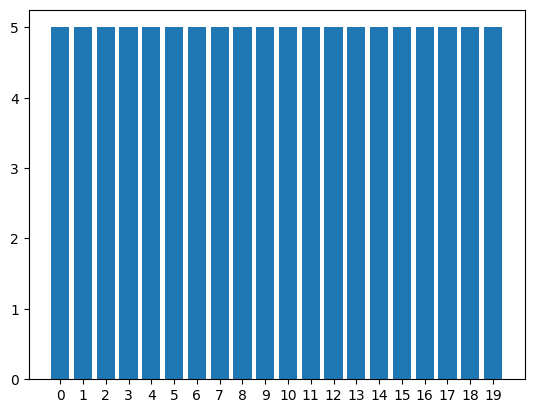

In [10]:
# evaluate our model (eval set)
scores = []
scores_task = []
for task in [15]: #range(20):
    eval_dataset = Dataset.from_pandas(dfsimple).select(range(n_train,n_train+20)) # Dataset.from_pandas(task_samples[task]).select(range(n_eval))
    for eval_data in tqdm(eval_dataset):
        print("============================================")
        print("Test input")
        render_grid(eval_data["test"][0]['input'])

        print("Predict output")
        preds = solver.predict(eval_data)
        if preds is not None: render_grid(preds)

        print("Test output")
        render_grid(eval_data["test"][0]['output'])
        print("============================================")
        if preds is None: s = 0
        else: s = check_match(preds, eval_data["test"][0]["output"])
        scores.append(s)
    score = np.array(scores).mean() * 100
    scores_task.append(score)
    print(f"Evaluation score: {score:.2f}", flush=True)
    scores = []

from matplotlib import pyplot as plt
x = np.arange(20)
plt.bar(x, scores_task)
plt.xticks(x, list(range(20)))
plt.show()